📁 Experiment results will be saved to: ./data/experiment_20260128_025314
Data loaded: Train=160, Test=40

🚀 Training started...
  Epoch  5: Loss = 1.0994
  Epoch 10: Loss = 0.9531
  Epoch 15: Loss = 0.8260
  Epoch 20: Loss = 0.7227
✅ Training finished in 7.25 sec
💾 Saved plot to: ./data/experiment_20260128_025314/learning_curve.png


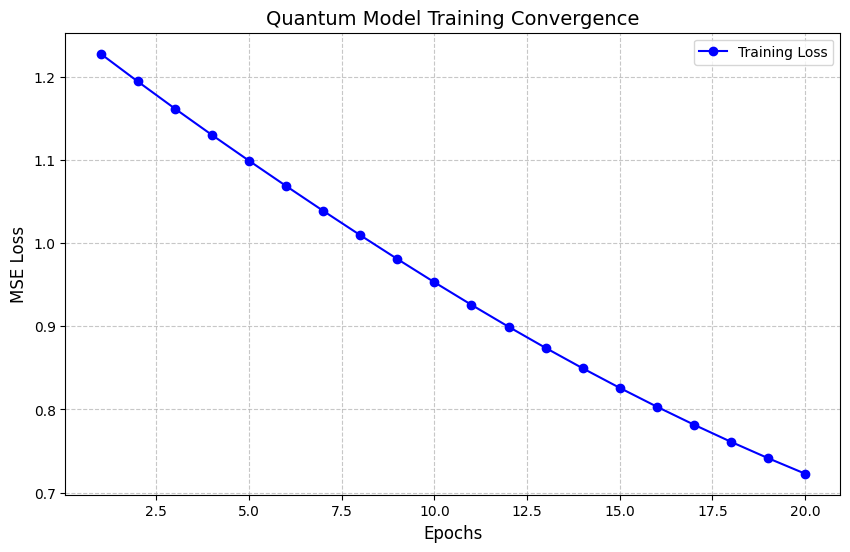

💾 Saved plot to: ./data/experiment_20260128_025314/decision_boundary.png


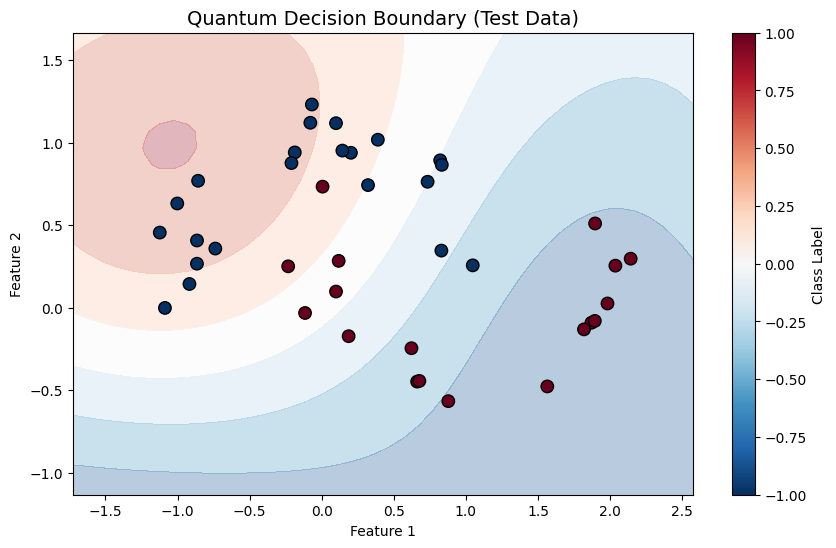


🎉 All tasks completed. Check the './data/experiment_20260128_025314' directory.


In [1]:
# ==========================================
# 1. Imports & Environment Setup
# ==========================================
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Scikit-learn for data generation and splitting
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
import pennylane as qml
from pennylane import numpy as pnp

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --- Setup Output Directory ---
# Relative path from the notebook location
output_base_dir = "./outputs"
# Create a timestamped subdirectory for this experiment
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join(output_base_dir, f"experiment_{timestamp}")

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
print(f"📁 Experiment results will be saved to: {save_dir}")

# ==========================================
# 2. Data Preparation (Two Moons)
# ==========================================
n_samples = 200
# Generate synthetic dataset
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

# Convert labels to -1 and 1 to match Pauli-Z measurement expectations
y = 2 * y - 1 

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data loaded: Train={len(X_train)}, Test={len(X_test)}")

# ==========================================
# 3. Quantum Model Definition
# ==========================================
n_qubits = 2
# Use 'lightning.qubit' for faster CPU simulation
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Data Encoding (Angle Embedding)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    
    # Variational Layer (Entangling layers with trainable weights)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    # Measurement (Expectation value of Pauli-Z on the 0th qubit)
    return qml.expval(qml.PauliZ(0))

# Hyperparameters
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

# Initialize the Quantum Layer (converting QNode to a Torch Layer)
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# ==========================================
# 4. Training Loop
# ==========================================
# Optimizer and Loss Function
opt = torch.optim.Adam(qlayer.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

epochs = 20
loss_history = []

print("\n🚀 Training started...")
start_time = time.time()

for epoch in range(epochs):
    opt.zero_grad()
    
    # Forward pass
    predictions = qlayer(X_train_torch)
    
    # Calculate loss
    loss = loss_fn(predictions.flatten(), y_train_torch)
    
    # Backward pass and optimization
    loss.backward()
    opt.step()
    
    # Record loss
    loss_val = loss.item()
    loss_history.append(loss_val)
    
    if (epoch + 1) % 5 == 0:
        print(f"  Epoch {epoch+1:2d}: Loss = {loss_val:.4f}")

total_time = time.time() - start_time
print(f"✅ Training finished in {total_time:.2f} sec")

# ==========================================
# 5. Visualization & Saving
# ==========================================

def save_and_show(fig, name):
    """Helper function to save and display plots."""
    path = os.path.join(save_dir, name)
    fig.savefig(path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved plot to: {path}")
    plt.show()

# --- Plot 1: Learning Curve ---
fig_loss = plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, 'b-o', label='Training Loss')
plt.title('Quantum Model Training Convergence', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
save_and_show(fig_loss, "learning_curve.png")

# --- Plot 2: Decision Boundary (Prediction Visualization) ---
fig_pred = plt.figure(figsize=(10, 6))

# Create a mesh grid for background coloring
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on all grid points
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = qlayer(grid_tensor).reshape(xx.shape)

# Draw the decision boundary (background)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# Scatter plot of test data
# Color-coded by true class labels
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                      cmap=plt.cm.RdBu_r, edgecolors='k', s=80)

plt.title('Quantum Decision Boundary (Test Data)', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Class Label')
save_and_show(fig_pred, "decision_boundary.png")

print(f"\n🎉 All tasks completed. Check the '{save_dir}' directory.")